# Prep-Package

In [57]:
!git clone https://github.com/JimYeung/Self-Driving-Car.git

!ls Self-Driving-Car

!pip3 install imgaug

fatal: destination path 'Track' already exists and is not an empty directory.
driving_log.csv  IMG


In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn import utils
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath #edit the path
import random

**Collecting Data**

In [59]:
datadir = 'Self-Driving-Car/data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
#data.head()

def path_leaf(path):
  #Triming the data by keeping the tail only, i.e. center/right/left_***.jpg
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,center_2020_08_28_14_41_58_353.jpg,left_2020_08_28_14_41_58_353.jpg,right_2020_08_28_14_41_58_353.jpg,0.00,0.0,0.0,25.06343
1,center_2020_08_28_14_41_58_425.jpg,left_2020_08_28_14_41_58_425.jpg,right_2020_08_28_14_41_58_425.jpg,0.00,0.0,0.0,24.91137
2,center_2020_08_28_14_41_58_497.jpg,left_2020_08_28_14_41_58_497.jpg,right_2020_08_28_14_41_58_497.jpg,0.10,0.0,0.0,24.70728
3,center_2020_08_28_14_41_58_571.jpg,left_2020_08_28_14_41_58_571.jpg,right_2020_08_28_14_41_58_571.jpg,0.30,0.0,0.0,24.46255
4,center_2020_08_28_14_41_58_645.jpg,left_2020_08_28_14_41_58_645.jpg,right_2020_08_28_14_41_58_645.jpg,0.45,0.0,0.0,24.23326


# **Balancing Data**
1.   Given frequency of some steering angle(e.g. 0.00) is much higher than the rest, 
We need to spread the data uniformly by setting threshold.
2.   Instead of cutting data beyond threshold directly(which leads to lost of data of the latter track), we shuffle and trim the data randomly. This preserves the whole tracks info expcept they are discountinous after trimming.





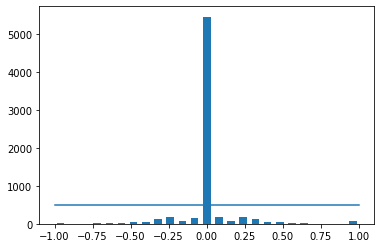

In [60]:
#Displaying the distribution of steering angles
samples_per_bin = 500 #Threshold for uniforming the samples 
num_bins = 25 #no. of categories of steering angles
hist, bins = np.histogram(data['steering'], num_bins) #bins = categories of steering angle
center = (bins[:-1]+ bins[1:])*0.5 #centering the hist
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))#Drawing the threshold line

total data 6954
remove 4963
remaining 1991


<BarContainer object of 25 artists>

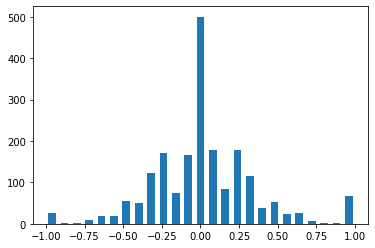

In [61]:
print('total data', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i) #categorizing the steering angle
  random.shuffle(list_)
  #print(len(list_))
  list_ = list_[samples_per_bin: ] #eject samples that is beyond the threshold
  remove_list.extend(list_) #listing the unwanted data

print('remove', len(remove_list))
data.drop(data.index[remove_list], inplace=True) #removing the unwanted data by accessing their index
print('remaining', len(data))
hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width = 0.05)
#plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))#Drawing the threshold line

In [62]:
print(data.iloc[1])
def load_img_steering(datadir, df): #df = dataframe 
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i] #iloc: select data via index i
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))#strip() to remove any spaces
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)

  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2020_08_28_14_41_58_571.jpg
left        left_2020_08_28_14_41_58_571.jpg  
right       right_2020_08_28_14_41_58_571.jpg 
steering    0.3                               
throttle    0                                 
reverse     0                                 
speed       24.4626                           
Name: 3, dtype: object


# Splitting Data

In [63]:
#Splitting into training & validation data
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\n Valid Samples: {}'. format(len(X_train), len(X_valid)))

Training Samples: 1592
 Valid Samples: 399


Text(0.5, 1.0, 'Validation Set')

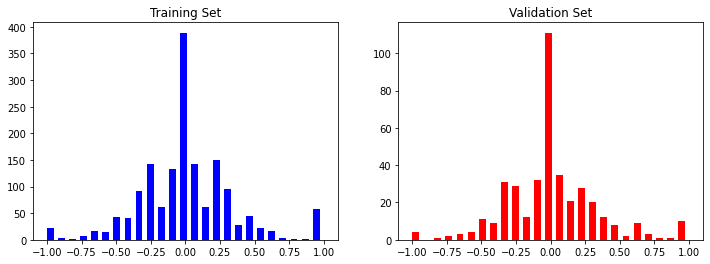

In [64]:
#Checking the split of the data: similar distribution
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins = num_bins, width=0.05, color='blue')
axes[0].set_title('Training Set')
axes[1].hist(y_valid, bins = num_bins, width=0.05, color='red')
axes[1].set_title('Validation Set')

# **Preprocessing Data**

In [65]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

In [66]:
# image = image_paths[random.randint(0,len(X_train)-1)]
# original_image= mpimg.imread(image)
# zoomed_image = zoom(original_image)

# fig, axs = plt.subplots(1,2, figsize=(15,10))
# fig.tight_layout()
# axs[0].imshow(original_image)
# axs[0].set_title('Original Image')

# axs[1].imshow(zoomed_image)
# axs[1].set_title('Zoomed Image')

In [67]:
def pan(image):
  pan = iaa.Affine(translate_percent={'x': (-0.1,0.1), 'y': (-0.1,0.1)})
  image = pan.augment_image(image)
  return image

In [68]:
# image = image_paths[random.randint(0,len(X_train)-1)]
# original_image= mpimg.imread(image)
# pan_image = pan(original_image)

# fig, axs = plt.subplots(1,2, figsize=(15,10))
# fig.tight_layout()
# axs[0].imshow(original_image)
# axs[0].set_title('Original Image')

# axs[1].imshow(pan_image)
# axs[1].set_title('Panned Image')

In [69]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

In [70]:
# image = image_paths[random.randint(0,len(X_train)-1)]
# original_image= mpimg.imread(image)
# bright_altered_image = img_random_brightness(original_image)

# fig, axs = plt.subplots(1,2, figsize=(15,10))
# fig.tight_layout()
# axs[0].imshow(original_image)
# axs[0].set_title('Original Image')

# axs[1].imshow(bright_altered_image)
# axs[1].set_title('Bright_altered Image')

In [71]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)

  steering_angle = -steering_angle
  return image, steering_angle

In [72]:
# random_index = random.randint(0,len(X_train)-1)
# image = image_paths[random.randint(0,len(X_train)-1)]
# steering_angle = steerings[random_index]
# print(steering_angle)

# original_image= mpimg.imread(image)
# flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

# fig, axs = plt.subplots(1,2, figsize=(15,10))
# fig.tight_layout()
# axs[0].imshow(original_image)
# axs[0].set_title('Original Image' + 'Steering Angle'+str(steering_angle))


# axs[1].imshow(flipped_image)
# axs[1].set_title('Bright_altered Image' + 'Steering Angle'+ str(flipped_steering_angle))


In [73]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66)) #Resize to fit NVidia data architecture
  return img/255

In [74]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

In [75]:
# ncol = 2
# nrow = 10
# fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
# fig.tight_layout()

# for i in range(10):
#   randnum = random.randint(0,len(X_train)-1)
#   random_image = image_paths[randnum]
#   random_steering = steerings[randnum]

#   original_image = mpimg.imread(random_image)
#   augmented_image, steering = random_augment(random_image, random_steering)

#   axs[i][0].imshow(original_image)
#   axs[i][0].set_title('original image')
#   axs[i][1].imshow(augmented_image)
#   axs[i][1].set_title('augmented image')

Track/IMG/center_2020_08_28_14_42_24_503.jpg


Text(0.5, 1.0, 'preprocessed_image')

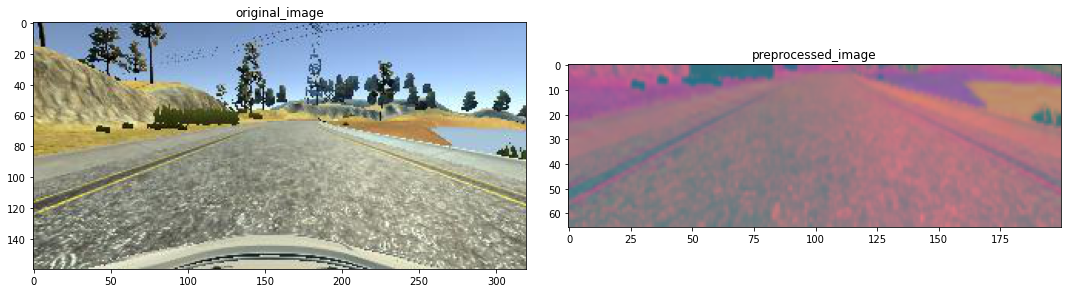

In [76]:
image = image_paths[100]
print(image)
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original_image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed_image')

# Batch_Generator
Generator: process the data as you go. Instead of preparing all the data before ready to go, generator returns data as the processes go. For the former method, all the processed data is stored inside a list which could costs a large memory storage. While generator doesn't stored the processed data in list but passing to the caller whenever it is called, i.e. storing in list is no-longer necessary!

In [77]:

def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)

      if istraining: 
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.array(batch_img), np.asarray(batch_steering))


Text(0.5, 1.0, 'Valid_image')

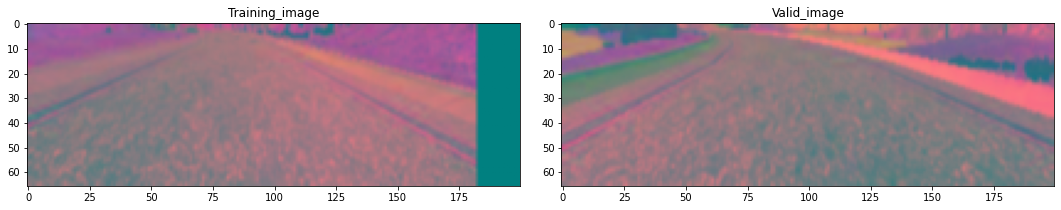

In [78]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 2, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 2, 0))

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training_image')
axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Valid_image')

In [79]:
# Only without self-made batch

# X_train = np.array(list(map(img_preprocess, X_train)))
# X_val = np.array(list(map(img_preprocess, X_valid)))


In [80]:
# plt.imshow(X_train[random.randint(0,(len(X_train)-1))])
# plt.axis('off')
# print(X_train.shape)
# print(X_val.shape)

# **Defining Nvidia Model**
  - NVidia model is proposed by NVidia for behavioural Cloning which is used for self-driving cars
  - Using ReLu function leads to lead relu: where the negative values gradient back propagations are being picked up (not learnt)


In [81]:
def nvidia_model():
 
  model = Sequential()
  
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  #model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))
  
  
  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Dense(1)) #This is the vehicle Control *****

  
  optimizer= Adam(lr=2e-4)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

In [82]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

In [83]:
n_images = len(X_train)
n_images_val = len(X_valid)
#X_train = X_train.reshape(n_images,66,200,3)
#X_valid = X_valid.reshape(n_images_val,66,200,3)
print(X_train.shape)

(1592,)


# Training

In [84]:
#history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)
history = model.fit_generator(batch_generator(X_train, y_train,130, 1),
                              steps_per_epoch=350, 
                              epochs=10, 
                              validation_data=batch_generator(X_valid, y_valid,130,0),
                              validation_steps=250,
                              verbose=1, shuffle=1)


Epoch 1/10
370/370 [==============================] - 324s 874ms/step - loss: 0.1032 - val_loss: 0.0723
Epoch 2/10
370/370 [==============================] - 322s 871ms/step - loss: 0.0886 - val_loss: 0.0686
Epoch 3/10
176/370 [=============>................] - ETA: 2:05 - loss: 0.0803

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','Validation'])
plt.title("Loss")
plt.xlabel("Epochs")

**Save & DL model**

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')